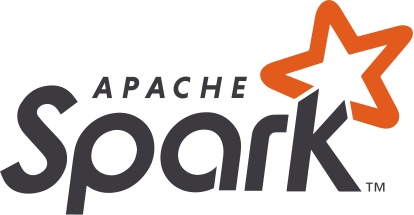

<a id='0'></a>
## Objective
**Customer Understanding & Segmentation**  
- Profile customers by age, gender, and spending patterns  
- Be able to segment customer by following clustering methods, such as K-means

**Predicting churn in our customers**
- Implement different Machine Learning models to our dataset in order to predict churn between our customers
- Store the best Machine Learning model in HDFS and the summary of the results in MariaDB

These objectives will inform key decisions that will enhance overall business growth

### Environment setup:

We will import some packages that we will need during the running of the notebook

As we will store our final results in MariaDB, Spark needs to know how to access MariaDB, therefore it needs a reference to the MariaDB driver.

Time to create the Spark Session before we can do any other thing. Remember, the Spark Session is the entry point to programming Spark with the DataFrame API (High-level API).


In [3]:
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.mariadb.jdbc:mariadb-java-client:3.3.0" pyspark-shell'
os.environ['PYSPARK_PYTHON'] = '/home/osbdet/.jupyter_venv/bin/python'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, expr
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder \
    .appName("EcommerceAnalyticsHub") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.sql.caseSensitive", "true")\
    .config("spark.jars.packages", "org.mariadb.jdbc:mariadb-java-client:3.3.0")\
    .getOrCreate()


25/01/14 18:47:29 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
25/01/14 18:47:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/osbdet/.jupyter_venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
org.mariadb.jdbc#mariadb-java-client added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8783d09d-b5f0-4335-90e4-19cff22451f6;1.0
	confs: [default]
	found org.mariadb.jdbc#mariadb-java-client;3.3.0 in central
	found com.github.waffle#waffle-jna;3.3.0 in central
	found net.java.dev.jna#jna;5.13.0 in central
	found net.java.dev.jna#jna-platform;5.13.0 in central
	found org.slf4j#jcl-over-slf4j;2.0.7 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found com.github.ben-manes.caffeine#caffeine;2.9.3 in central
	found com.google.errorprone#error_prone_annotations;2.10.0 in central
	found org.checkerframework#checker-qual;3.32.0 in central
:: resolution report :: resolve 562ms :: artifacts dl 40ms
	:: modules in use:
	com.github.ben-manes.caffeine#caffeine;2.9.3 from central in [default]
	com.github.waffle#waffle-jna;3.3.0 from central in 

### Data Loading:

Creation of the Spark session and upload the dataset previously stored in HDFS


In [5]:
file_path = "hdfs://localhost:9000/datalake/raw/final/"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(10)

+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|Customer ID|      Purchase Date|Product Category|Product Price|Quantity|Total Purchase Amount|Payment Method|Customer Age|Returns| Customer Name|Age|Gender|Churn|
+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|      44605|2023-05-03 21:30:02|            Home|          177|       1|                 2427|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2021-05-16 13:57:44|     Electronics|          174|       3|                 2448|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2020-07-13 06:16:57|           Books|          413|       1|                 2345|   Credit Card|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|202

In [6]:
df.limit(10).toPandas()

Customer ID       Purchase Date Product Category  Product Price  Quantity  \
0        44605 2023-05-03 21:30:02             Home            177         1   
1        44605 2021-05-16 13:57:44      Electronics            174         3   
2        44605 2020-07-13 06:16:57            Books            413         1   
3        44605 2023-01-17 13:14:36      Electronics            396         3   
4        44605 2021-05-01 11:29:27            Books            259         4   
5        13738 2022-08-25 06:48:33             Home            191         3   
6        13738 2023-07-25 05:17:24      Electronics            205         1   
7        13738 2023-02-05 19:31:48            Books            370         5   
8        13738 2021-12-21 03:29:05             Home             12         2   
9        13738 2023-02-09 00:53:14      Electronics             40         4   

   Total Purchase Amount Payment Method  Customer Age  Returns  \
0                   2427         PayPal            31      1.0   
1                   2448         PayPal            31      1.0   
2                   2345    Credit Card            31      1.0   
3                    937           Cash            31      0.0   
4                   2598         PayPal            31      1.0   
5                   3722    Credit Card            27      1.0   
6                   2773    Credit Card            27      NaN   
7                   1486           Cash            27      1.0   
8                   2175           Cash            27      NaN   
9                   4327           Cash            27      0.0   

    Customer Name  Age  Gender  Churn  
0     John Rivera   31  Female      0  
1     John Rivera   31  Female      0  
2     John Rivera   31  Female      0  
3     John Rivera   31  Female      0  
4     John Rivera   31  Female      0  
5  Lauren Johnson   27  Female      0  
6  Lauren Johnson   27  Female      0  
7  Lauren Johnson   27  Female      0  
8  Lauren Johnson   27  Female      0  
9  Lauren Johnson   27  Female      0

### EDA (Exploratory Data Analysis) and Data Cleaning:
- Explored the dataset by summarizing statistics and identifying trends to understand the data better.
- Handled missing values, resolved inconsistencies, and detected outliers to ensure data quality.

In [7]:
df.describe().toPandas()

25/01/14 18:48:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


summary         Customer ID Product Category      Product Price  \
0   count              250000           250000             250000   
1    mean        25017.632092             None         254.742724   
2  stddev  14412.515718385517             None  141.7381040786859   
3     min                   1            Books                 10   
4     max               50000             Home                500   

             Quantity Total Purchase Amount Payment Method       Customer Age  \
0              250000                250000         250000             250000   
1            3.004936           2725.385196           None          43.798276   
2  1.4147365980360334    1442.5760947288732           None  15.36491509089087   
3                   1                   100           Cash                 18   
4                   5                  5350         PayPal                 70   

             Returns    Customer Name                Age  Gender  \
0             202618           250000             250000  250000   
1  0.500824211077002             None          43.798276    None   
2  0.500000554527445             None  15.36491509089087    None   
3                0.0  Aaron Alexander                 18  Female   
4                1.0        Zoe Young                 70    Male   

                 Churn  
0               250000  
1              0.20052  
2  0.40039027317041814  
3                    0  
4                    1

In [8]:
missing_values_count = {}

for column in df.columns:
    missing_count = df.filter((col(column).isNull()) | (col(column) == "") | (col(column).rlike("^\s*$"))).count()
    missing_values_count[column] = missing_count

print("\t\t\t\t\t_____________________________________")
print("\t\t\t\t\t|  Missing Values Count per Column  |")
print("\t\t\t\t\t|___________________________________|")
print("\n\n")
for column, count in missing_values_count.items():
    print(f"{column}: {count}")

					_____________________________________
					|  Missing Values Count per Column  |
					|___________________________________|



Customer ID: 0
Purchase Date: 0
Product Category: 0
Product Price: 0
Quantity: 0
Total Purchase Amount: 0
Payment Method: 0
Customer Age: 0
Returns: 47382
Customer Name: 0
Age: 0
Gender: 0
Churn: 0


In [9]:
print("\t\t\t\t\t___________________________________________")
print("\t\t\t\t\t|  Unique values for categorical columns  |")
print("\t\t\t\t\t|_________________________________________|")
print("\n\n")
df.select("Product Category").distinct().toPandas()
df.select("Gender").distinct().toPandas()
df.select("Payment Method").distinct().toPandas()

					___________________________________________
					|  Unique values for categorical columns  |
					|_________________________________________|





Product Category
0             Home
1      Electronics
2         Clothing
3            Books

Gender
0  Female
1    Male

Payment Method
0    Credit Card
1         PayPal
2           Cash

In [10]:
print("\t\t\t\t\t_________________________________________________")
print("\t\t\t\t\t|  Count Unique values for categorical columns  |")
print("\t\t\t\t\t|_______________________________________________|")
print("\n\n")
df.groupBy("Gender").count().toPandas()
df.groupBy("Payment Method").count().toPandas()
df.groupBy("Product Category").count().toPandas()

					_________________________________________________
					|  Count Unique values for categorical columns  |
					|_______________________________________________|





Gender   count
0  Female  124324
1    Male  125676

Payment Method  count
0    Credit Card  83547
1         PayPal  83441
2           Cash  83012

Product Category  count
0             Home  62542
1      Electronics  62630
2         Clothing  62581
3            Books  62247

In [11]:
print("\t\t\t\t________________________________________________________________")
print("\t\t\t\t| Correlation between Product Price and Total Purchase Amount  |")
print("\t\t\t\t|______________________________________________________________|")
print("\n\n")
correlation = df.stat.corr("Product Price", "Total Purchase Amount")
print(f"Correlation: {correlation}")

				________________________________________________________________
				| Correlation between Product Price and Total Purchase Amount  |
				|______________________________________________________________|



Correlation: -0.0012972970953190794


In [12]:
# Print header with improved formatting
print("\n\t\t\t\t--------------------------------")
print("\t\t\t\t|  Insights Through Aggregation  |")
print("\t\t\t\t----------------------------------")
print("\n\n")

# Sum of Total Purchase Amount
sum_purchase = df.agg({"Total Purchase Amount": "sum"}).toPandas()
print("Total Purchase Amount (Sum):".ljust(50), sum_purchase.iloc[0, 0])
print("-" * 100)

# Average of Product Price
avg_price = df.agg({"Product Price": "avg"}).toPandas()
print("Average Product Price:".ljust(50), avg_price.iloc[0, 0])
print("-" * 100)


				--------------------------------
				|  Insights Through Aggregation  |
				----------------------------------



Total Purchase Amount (Sum):                       681346299
----------------------------------------------------------------------------------------------------
Average Product Price:                             254.742724
----------------------------------------------------------------------------------------------------


In [10]:
from pyspark.sql import functions as F
# Total purchase amount by product category
df.groupBy("Product Category").sum("Total Purchase Amount").orderBy(F.desc("sum(Total Purchase Amount)")).toPandas()

Product Category  sum(Total Purchase Amount)
0             Home                   171138916
1         Clothing                   170716122
2      Electronics                   170146025
3            Books                   169345236

In [15]:
# Average purchase by age group
# Create age groups
df = df.withColumn("Age Group", F.when(df["Age"] < 20, "Under 20")
                                  .when((df["Age"] >= 20) & (df["Age"] < 40), "20-39")
                                  .when((df["Age"] >= 40) & (df["Age"] < 60), "40-59")
                                  .otherwise("60+"))

df.groupBy("Age Group").avg("Total Purchase Amount").orderBy(F.desc("avg(Total Purchase Amount)")).toPandas()


Age Group  avg(Total Purchase Amount)
0       60+                 2836.629993
1     40-59                 2757.896155
2     20-39                 2647.258839
3  Under 20                 2591.438086

In [16]:
# Churn rate by payment method and by gender
df.groupBy("Payment Method", "Churn").count().toPandas()

df.groupBy("Gender", "Churn").count().toPandas()

Payment Method  Churn  count
0           Cash      0  66200
1    Credit Card      0  67120
2    Credit Card      1  16427
3           Cash      1  16812
4         PayPal      0  66550
5         PayPal      1  16891

Gender  Churn   count
0    Male      1   25063
1  Female      0   99257
2    Male      0  100613
3  Female      1   25067

In [17]:
# Average spend per customer (for Churned and non-churned)
df.groupBy("Churn").avg("Total Purchase Amount").toPandas()


Churn  avg(Total Purchase Amount)
0      1                 2727.417614
1      0                 2724.875439

In [11]:
print("\t\t\t\t_______________________________________")
print("\t\t\t\t| Resolving Missing Values in Returns |")
print("\t\t\t\t|_____________________________________|")
print("\n\n")

#Filling Missing Values with 0
df_cleaned = df.fillna({"Returns": 0.0})
missing_values_count = {}
for column in df_cleaned.columns:
    missing_count = df_cleaned.filter((col(column).isNull()) | (col(column) == "") | (col(column).rlike("^\s*$"))).count()
    missing_values_count[column] = missing_count

for column, count in missing_values_count.items():
    print(f"{column}: {count}")

				_______________________________________
				| Resolving Missing Values in Returns |
				|_____________________________________|





Customer ID: 0
Purchase Date: 0
Product Category: 0
Product Price: 0
Quantity: 0
Total Purchase Amount: 0
Payment Method: 0
Customer Age: 0
Returns: 0
Customer Name: 0
Age: 0
Gender: 0
Churn: 0


In [12]:
print("\t\t\t\t_____________________")
print("\t\t\t\t| Outlier Detection |")
print("\t\t\t\t|___________________|")
print("\n\n")
def detect_outliers(df, column_name):
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(f"{column_name} - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    outliers = df.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound))
    return outliers, lower_bound, upper_bound

product_price_outliers, product_price_lower, product_price_upper = detect_outliers(df_cleaned, "Product Price")
print("\n")
purchase_amount_outliers, purchase_amount_lower, purchase_amount_upper = detect_outliers(df_cleaned, "Total Purchase Amount")
print("\n")

if product_price_outliers.count() == 0 and purchase_amount_outliers.count() == 0:
    print("--> No outliers detected in both columns.")
else:
    if product_price_outliers.count() > 0:
        print("Outliers in Product Price:")
        product_price_outliers.select("Product Price").show()
    if purchase_amount_outliers.count() > 0:
        print("Outliers in Total Purchase Amount:")
        purchase_amount_outliers.select("Total Purchase Amount").show()

				_____________________
				| Outlier Detection |
				|___________________|





Product Price - Lower Bound: -235.5, Upper Bound: 744.5




Total Purchase Amount - Lower Bound: -2272.5, Upper Bound: 7723.5




--> No outliers detected in both columns.


In [20]:
df_cleaned.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Purchase Date: timestamp (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Product Price: integer (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Total Purchase Amount: integer (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Customer Age: integer (nullable = true)
 |-- Returns: double (nullable = false)
 |-- Customer Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- Age Group: string (nullable = false)



### K-Means Clustering:

#### Cluster Assignment: 
The clustering process has grouped the data based on features such as product price, quantity, total purchase amount, and customer age. Each row in the dataset has been assigned to one of the five clusters (as seen in the prediction column in the clustering output).

#### Silhouette Score: 
The silhouette score of 0.314 indicates that the clustering quality is average. A score closer to 1 would indicate well-separated clusters, whereas a score closer to 0 means that the clusters are not well-defined. The relatively low silhouette score suggests that the current number of clusters (5) may not be ideal, and further tuning (such as experimenting with different cluster numbers) could improve the results.

#### Visualization: 
The scatter plot visually presents the clusters based on "Product Price" and "Total Purchase Amount," where each data point is colored according to its assigned cluster. This visualization can provide insights into how well the clusters are separated and help you identify trends or patterns in the data, such as which clusters tend to have higher or lower product prices or purchase amounts.

In [13]:
print("\t\t\t\t______________________")
print("\t\t\t\t| K-Means Clustering |")
print("\t\t\t\t|____________________|")
print("\n\n")
numerical_columns = ["Product Price", "Quantity", "Total Purchase Amount", "Customer Age"]
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="Features")
df_features = assembler.transform(df_cleaned)
scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures", withStd=True, withMean=False)
df_scaled = scaler.fit(df_features).transform(df_features)
#K-Means Clustering
kmeans = KMeans(featuresCol="ScaledFeatures", k=5, seed=45)
kmeans_model = kmeans.fit(df_scaled)
df_clustered = kmeans_model.transform(df_scaled)
df_clustered.select("Product Price", "Quantity", "Total Purchase Amount", "Customer Age", "prediction").toPandas()
evaluator = ClusteringEvaluator(featuresCol="ScaledFeatures", metricName="silhouette")
silhouette_score = evaluator.evaluate(df_clustered)
print(f"Silhouette Score: {silhouette_score}")

				______________________
				| K-Means Clustering |
				|____________________|





25/01/14 18:50:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/14 18:50:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Product Price  Quantity  Total Purchase Amount  Customer Age  \
0                 177         1                   2427            31   
1                 174         3                   2448            31   
2                 413         1                   2345            31   
3                 396         3                    937            31   
4                 259         4                   2598            31   
...               ...       ...                    ...           ...   
249995            436         1                   3664            63   
249996            233         1                   4374            66   
249997            441         5                   5296            63   
249998             44         2                   2517            64   
249999            307         5                   3634            32   

        prediction  
0                0  
1                0  
2                4  
3                1  
4                2  
...            ...  
249995           4  
249996           4  
249997           4  
249998           0  
249999           2  

[250000 rows x 5 columns]

Silhouette Score: 0.3144720398938786


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 1.0, 'Clusters: Product Price vs Total Purchase Amount')

Text(0.5, 0, 'Product Price')

Text(0, 0.5, 'Total Purchase Amount')

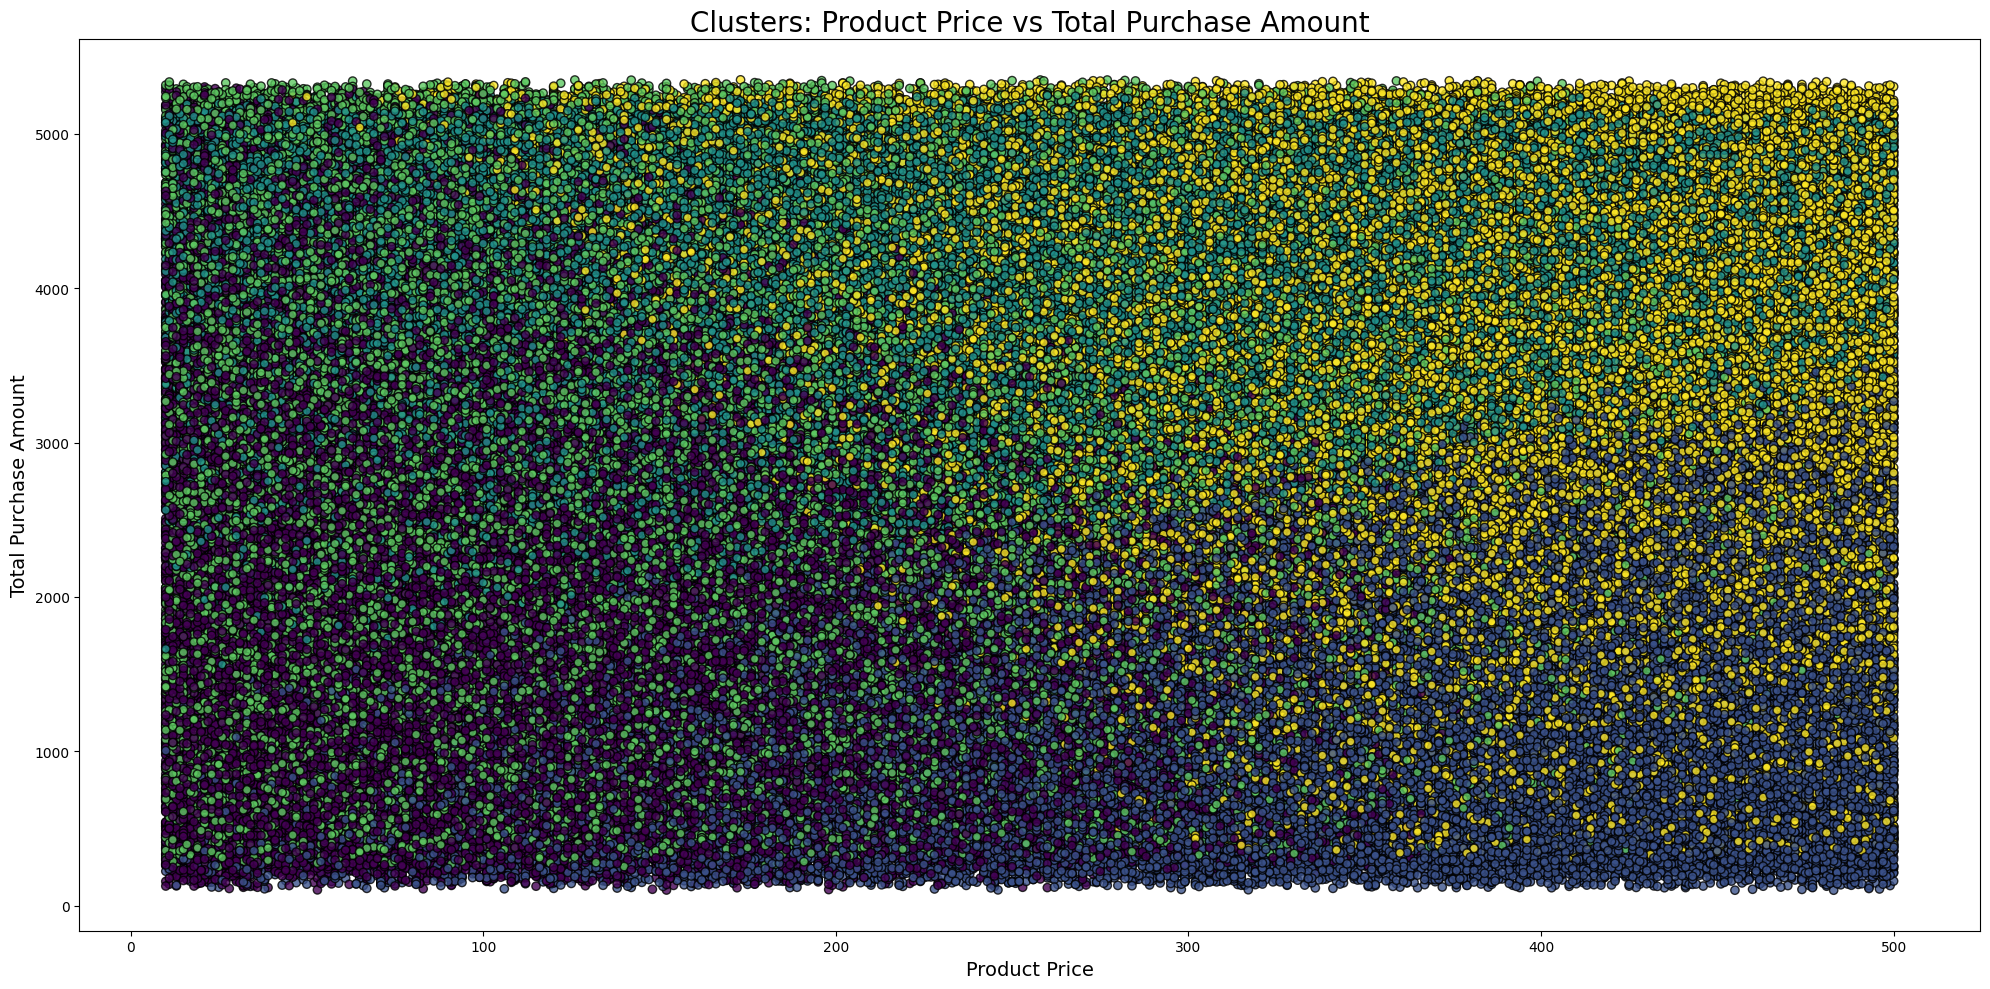

In [14]:
df_pandas = df_clustered.select("Product Price", "Quantity", "Total Purchase Amount", "Customer Age", "prediction").toPandas()

#Product Price vs Total Purchase Amount
plt.figure(figsize=(20,10))
scatter = plt.scatter(df_pandas["Product Price"], df_pandas["Total Purchase Amount"], c=df_pandas["prediction"],
    cmap="viridis", alpha=0.8,edgecolor='k' )

plt.title("Clusters: Product Price vs Total Purchase Amount", fontsize=20)
plt.xlabel("Product Price", fontsize=14)
plt.ylabel("Total Purchase Amount", fontsize=14)
plt.tight_layout()
plt.show()

### Feature Engineering
This step is very needed to adapt the dataset and provide it with a format that fits the different Machine Learning algorithms. Feature engineering is addressed by differents techniques. For our business case we have focused on:

- *StringIndexer* - to translate our categorical variables with a string data type into number.
- *OneHotEncoder* - it'll take the label index from the previous StringIndexer and will make a binary vector.
- *VectorAssembler* - to combine transformed categorical data and numerical data into a single column vector.

In [15]:
from pyspark.ml.feature import VectorAssembler

# Separate numeric and categorical columns
target_column = "Churn"
num_columns = [
    "Product Price", 
    "Quantity", 
    "Total Purchase Amount", 
    "Customer Age", 
    "Returns"
]

categorical_columns = ["Product Category", "Payment Method", "Gender"]


In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Preparation of the Feature Transformation PySpark objects

indexOutputCols = [x + "Index" for x in categorical_columns]
oheOutputCols = [x + "OHE" for x in categorical_columns]

stringIndexer = StringIndexer(inputCols=categorical_columns, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,outputCols=oheOutputCols)

In [25]:
debuging_df = stringIndexer.fit(df_cleaned).transform(df_cleaned)
debuging_df.toPandas()

Customer ID       Purchase Date Product Category  Product Price  \
0             44605 2023-05-03 21:30:02             Home            177   
1             44605 2021-05-16 13:57:44      Electronics            174   
2             44605 2020-07-13 06:16:57            Books            413   
3             44605 2023-01-17 13:14:36      Electronics            396   
4             44605 2021-05-01 11:29:27            Books            259   
...             ...                 ...              ...            ...   
249995        33807 2023-01-24 12:32:18             Home            436   
249996        20455 2021-06-04 05:45:25      Electronics            233   
249997        28055 2022-11-10 17:11:57      Electronics            441   
249998        15023 2021-06-27 14:42:12      Electronics             44   
249999         4148 2020-09-07 05:12:19             Home            307   

        Quantity  Total Purchase Amount Payment Method  Customer Age  Returns  \
0              1                   2427         PayPal            31      1.0   
1              3                   2448         PayPal            31      1.0   
2              1                   2345    Credit Card            31      1.0   
3              3                    937           Cash            31      0.0   
4              4                   2598         PayPal            31      1.0   
...          ...                    ...            ...           ...      ...   
249995         1                   3664           Cash            63      0.0   
249996         1                   4374    Credit Card            66      1.0   
249997         5                   5296           Cash            63      0.0   
249998         2                   2517           Cash            64      1.0   
249999         5                   3634           Cash            32      0.0   

            Customer Name  Age  Gender  Churn Age Group  \
0             John Rivera   31  Female      0     20-39   
1             John Rivera   31  Female      0     20-39   
2             John Rivera   31  Female      0     20-39   
3             John Rivera   31  Female      0     20-39   
4             John Rivera   31  Female      0     20-39   
...                   ...  ...     ...    ...       ...   
249995   Gabriel Williams   63    Male      0       60+   
249996       Barry Foster   66  Female      0       60+   
249997       Lisa Johnson   63  Female      0       60+   
249998  Melissa Fernandez   64    Male      0       60+   
249999      Angela Norton   32    Male      0     20-39   

        Product CategoryIndex  Payment MethodIndex  GenderIndex  
0                         2.0                  1.0          1.0  
1                         0.0                  1.0          1.0  
2                         3.0                  0.0          1.0  
3                         0.0                  2.0          1.0  
4                         3.0                  1.0          1.0  
...                       ...                  ...          ...  
249995                    2.0                  2.0          0.0  
249996                    0.0                  0.0          1.0  
249997                    0.0                  2.0          1.0  
249998                    0.0                  2.0          0.0  
249999                    2.0                  2.0          0.0  

[250000 rows x 17 columns]

In [1]:
debuging_df = oheEncoder.fit(debuging_df).transform(debuging_df)
debuging_df.toPandas()

NameError: name 'oheEncoder' is not defined

In [17]:
# Preparation of the Feature Transformation PySpark object to consolidate everything in one single vector

assemblerInputs = oheOutputCols + num_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

### Modeling:
Built predictive models using machine learning techniques:
- *Logistic Regression:* Used to predict the target variable based on input features.
- *DecisionTreeClassifier:* Decision tree learning algorithm for classification.
- *RandomForestClassifier:* Random Forest learning algorithm for classification.
- *Gradient-boosted Tree Classifier:* Gradient-Boosted Trees (GBTs) learning algorithm for classification.
- *NaiveBayes:* Naive Bayes Classifiers.
- *Linear Support Vector Machine:* This binary classifier optimizes the Hinge Loss using the OWLQN optimizer. Only supports L2 regularization currently.
- Models were trained and validated on the dataset, and performance metrics like AUC were evaluated to select the best model.

In [18]:
seed=11 # prime number; used to get always the same results and make the exercise repeatable

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC

lr = LogisticRegression(labelCol="Churn", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="Churn", featuresCol="features",seed=seed)
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features",maxDepth=10,seed=seed)
gbt = GBTClassifier(labelCol="Churn", featuresCol="features",maxIter=10,seed=seed)
nb = NaiveBayes(labelCol="Churn", featuresCol="features")
svm = LinearSVC(labelCol="Churn", featuresCol="features")

classifiers = [lr,dt,rf,gbt,nb,svm]
classifiers

[LogisticRegression_a9c6c6af1d7d,
 DecisionTreeClassifier_e82d9bc363fb,
 RandomForestClassifier_5d0c9c7fd277,
 GBTClassifier_fec4f56c956d,
 NaiveBayes_1dbfd4734a07,
 LinearSVC_96468838d66c]

In [19]:
from pyspark.ml import Pipeline

def create_pipeline(classifier):
    return Pipeline(stages = [stringIndexer, oheEncoder, assembler, classifier])

pipelines = [create_pipeline(classifier) for classifier in classifiers]
pipelines

[Pipeline_5fe03cb31995,
 Pipeline_574f69789d65,
 Pipeline_708a250a16ae,
 Pipeline_4850bc4b812f,
 Pipeline_dafa7fb5d0ed,
 Pipeline_70694264258c]

In [20]:
from pyspark.sql import DataFrame

# Function to perform stratified split
def stratified_split(df: DataFrame, target_column: str, train_fraction: float, seed: int):
    # Get the class distribution in the target column
    class_counts = df.groupBy(target_column).count().collect()
    
    # Create a dictionary where each class will have the same fraction for stratified sampling
    fractions = {row[target_column]: train_fraction for row in class_counts}
    
    # Sample the training set
    train_data = df.sampleBy(target_column, fractions, seed=seed)
    
    # Exclude training data from the original dataset to get the validation set
    validation_data = df.subtract(train_data)
    
    return train_data, validation_data

# Perform the stratified split
train_fraction = 0.8  # 80% training data
train_data, validation_data = stratified_split(df_cleaned, target_column="Churn", train_fraction=train_fraction, seed=42)

# Print counts for validation
print("\t\t\t\t_________________________________")
print("\t\t\t\t| Training & Testing Data Count |")
print("\t\t\t\t|_______________________________|")
print("\n")
print(f"Training Data Count: {train_data.count()}")
print(f"Validation Data Count: {validation_data.count()}")

# Check class distribution in training and validation sets
print("Training Class Distribution:")
train_data.groupBy("Churn").count().toPandas()

print("Validation Class Distribution:")
validation_data.groupBy("Churn").count().toPandas()

				_________________________________
				| Training & Testing Data Count |
				|_______________________________|


Training Data Count: 199948


Validation Data Count: 50052
Training Class Distribution:


Churn   count
0      1   40094
1      0  159854

Validation Class Distribution:


Churn  count
0      1  10036
1      0  40016

In [21]:
# Use BinaryClassificationEvaluator for AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderROC")

In [22]:
# Let's train all the models at once

models = [pipeline.fit(train_data) for pipeline in pipelines]
models

25/01/14 18:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1492.3 KiB
25/01/14 18:53:38 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[PipelineModel_0e860d8852ba,
 PipelineModel_dc671884ea6c,
 PipelineModel_c4cdd47b64d3,
 PipelineModel_7fc7a9f7b450,
 PipelineModel_10fb7fbadd3d,
 PipelineModel_9ecb09727b64]

In [23]:
# Initialize the lists to store model names and AUC values
names = []
values = []
model_names = []  # To store the model names along with IDs

# Iterate through the models
for model in models:
    prediction_df = model.transform(validation_data)
    auc = auc_evaluator.evaluate(prediction_df)
    
    # Extract the name of the algorithm (last stage in the pipeline)
    model_name = type(model.stages[-1]).__name__
    
    # Create a unique identifier for each model (e.g., pipeline name + model ID)
    model_id = f"{model_name}_{id(model)}"  # You can change this format as needed
    
    # Append the algorithm name, AUC, and model ID
    names.append(model_name)
    values.append(auc)
    model_names.append(model_id)

# Create a Spark DataFrame with the model name (including the model's pipeline name and ID)
data = [(name, auc, model_name) for name, auc, model_name in zip(names, values, model_names)]

# Create a Spark DataFrame
df_auc = spark.createDataFrame(data, ["name", "AUC", "model_name"])

# Sort the DataFrame by AUC in descending order
df_auc_sorted = df_auc.orderBy(F.col("AUC"), ascending=False)

# Show the sorted DataFrame
df_auc_sorted.show()


25/01/14 18:54:42 WARN DAGScheduler: Broadcasting large task binary with size 1128.4 KiB


+--------------------+------------------+--------------------+
|                name|               AUC|          model_name|
+--------------------+------------------+--------------------+
|GBTClassification...|0.5180314432616752|GBTClassification...|
|RandomForestClass...|0.5068353026963789|RandomForestClass...|
|LogisticRegressio...|0.5061849351032802|LogisticRegressio...|
|DecisionTreeClass...|0.5015155145096205|DecisionTreeClass...|
|     NaiveBayesModel|0.5000167890695457|NaiveBayesModel_1...|
|      LinearSVCModel| 0.496907683718063|LinearSVCModel_14...|
+--------------------+------------------+--------------------+



In [24]:
df_auc_sorted.toPandas()

name       AUC  \
0           GBTClassificationModel  0.518031   
1  RandomForestClassificationModel  0.506835   
2          LogisticRegressionModel  0.506185   
3  DecisionTreeClassificationModel  0.501516   
4                  NaiveBayesModel  0.500017   
5                   LinearSVCModel  0.496908   

                                        model_name  
0           GBTClassificationModel_140590994392272  
1  RandomForestClassificationModel_140590994282512  
2          LogisticRegressionModel_140590994190480  
3  DecisionTreeClassificationModel_140590881946640  
4                  NaiveBayesModel_140590994401872  
5                   LinearSVCModel_140590994403728

#### Logistic Regression: 
The Logistic Regression model achieved an AUC (Area Under the Curve) of 0.5061, which indicates a very weak model performance. This suggests that the model does not do a good job at distinguishing between the positive and negative classes.

#### Random Forest: 
The Random Forest model achieved an AUC of 0.5068, which is only slightly better than Logistic Regression but still relatively low. The slight improvement in AUC suggests that the Random Forest model's ensemble learning approach may provide some benefits over Logistic Regression, but there is still significant room for improvement.

#### Gradient Boosted Trees (GBT):
The Gradient Boosted Trees model outperformed all other models, achieving an AUC of 0.518. Although this is the highest among the tested models, it is still relatively low, indicating limited predictive power.

#### Decision Tree:
The Decision Tree model achieved an AUC of 0.502, performing only slightly above random guessing. This suggests that the Decision Tree model is insufficiently capturing patterns in the data.

#### Naive Bayes:
The Naive Bayes model produced an AUC of 0.500, which is equivalent to random guessing. This highlights that the model failed to learn any meaningful relationships in the data.

#### Linear Support Vector Classifier (Linear SVC):
The Linear SVC model achieved the lowest AUC of 0.497, falling below the threshold of random guessing. This result indicates that the Linear SVC model is not suitable for this dataset in its current form.

#### Model Comparison:
The Gradient Boosted Trees (GBT) model emerged as the best-performing model, albeit with an AUC of only 0.518. Random Forest (AUC: 0.507) and Logistic Regression (AUC: 0.506) followed closely, but their performance was still weak. Models such as Naive Bayes (AUC: 0.500) and Linear SVC (AUC: 0.497) showed little to no predictive power.

In conclusion, while the clustering and modeling steps have provided insights, the results suggest that there is room for improvement, both in terms of cluster quality and model performance. Consider adjusting the number of clusters in K-Means and further tuning your models or exploring more advanced techniques to achieve better predictive accuracy.

### Saving the model into HDFS:
- Loading the best model to HDFS for application to the dataset.

In [13]:
model_save_path = "hdfs://localhost:9000/datalake/raw/final_v3/"

# Filter the DataFrame for the GBTClassificationModel
GBTClassificationModel = df_auc_sorted.filter(df_auc_sorted['name'] == 'GBTClassificationModel')

# Write the filtered DataFrame to HDFS in Parquet format (or another format like CSV)
GBTClassificationModel.write.format("parquet").save(model_save_path)

print(f"GBT model saved to {model_save_path}")


AnalysisException: [PATH_ALREADY_EXISTS] Path hdfs://localhost:9000/datalake/raw/final_v3 already exists. Set mode as "overwrite" to overwrite the existing path.

### Persisting the results of the models
- Persisting the results of the models by loading them into MariaDB 

**Before we can store results in a relational database, we need to create the destination *database* and *table*.** The `batch_final_assignment.sql` file contains the SQL code to do so:

```
-- Drop the database if it exists
DROP DATABASE IF EXISTS final_assignment;

-- Create the database
CREATE DATABASE final_assignment;

-- Switch to the newly created database
USE final_assignment;

-- Create the table
CREATE TABLE model_results (
    name VARCHAR(255),     -- Model name
    AUC FLOAT,             -- AUC value
    model_name VARCHAR(255),           -- Pipeline number
    PRIMARY KEY (model_name)  -- Unique ID as primary key
);

```

We'll use the `mariadb` command line tool by opening a *Terminal* window from Jupyter and running the SQL script like this (don't copy the $ sign):

```
$ mariadb -u osbdet -p < batch_final_assignment.sql
```
**Note:** type `osbdet123$` **WHEN** you're asked for the password; remember that nothing will come up while typing, it's a security feature.

In [14]:
driver_name = "org.mariadb.jdbc.Driver"
connection_string = "jdbc:mariadb://localhost:3306/final_assignment"
table_name ="model_results"
user_name = "osbdet"
password = "osbdet123$"

# we'll replace the existing contents of the table with contents in the DataFrame
df_auc_sorted.write.format("jdbc")\
                           .mode("overwrite")\
                           .option("driver", driver_name)\
                           .option("url", connection_string)\
                           .option("dbtable", table_name)\
                           .option("user", user_name)\
                           .option("password", password)\
                           .save()

#### Verify the contents on the model_results table

We'll use the `mariadb` command line tool by opening a *Terminal* window from Jupyter and running the SQL script like this (don't copy the $ sign):

```
$ mariadb -u osbdet -p -D final_assignment -e "SELECT * FROM model_results;"
```
**Note:** type `osbdet123$` **WHEN** you're asked for the password; remember that nothing will come up while typing, it's a security feature.